The objective use the ARM ocean data and obtain a precipitation buoyancy relationship

In [147]:
import pathlib
import importlib
import multiprocessing
import matplotlib.pyplot as plt
import xarray as xr
import warnings
import numpy as np
from time import perf_counter
%matplotlib inline

In [148]:
import Process_ARM, Preprocess_precipbuoy_plotting, Plot_buoy_statistics

importlib.reload(Process_ARM)
importlib.reload(Preprocess_precipbuoy_plotting)
importlib.reload(Plot_buoy_statistics)

from Process_ARM import ProcessARM
from Preprocess_precipbuoy_plotting import BuoyPrecip
from Plot_buoy_statistics import plot_bl_stats

File locations to ARMBE data <br>
<b>TWPC1</b>(Manus; PNG), <b>TWPC2</b> (Nauru) and <b>TWPC3</b> (Darwin; Aus.)
    

In [149]:
arm_path = pathlib.Path('/neelin2020/ARM/')
arm_files = dict(TWPC1 = arm_path / 'TWPC1',
                TWPC2 = arm_path / 'TWPC2',
                TWPC3 = arm_path / 'TWPC3',
                CACTI = arm_path / 'CACTI')

In [150]:
# set variable list for ARM files here

# variable list for ARMBE files over oceans
var_dict_twp = dict(temp = 'T_p', tdp = 'Td_p', prc = 'prec_sfc',  
                    ps = 'p_sfc', uwind = 'u_p', vwind = 'v_p')

#variable list for CACTI ARMBE files 
var_dict_cacti = dict(temp = 'temperature_p', tdp = 'dewpoint_p', prc = 'precip_rate_sfc',  
                       ps = 'pressure_sfc', uwind = 'u_wind_p', vwind = 'v_wind_p', 
                       p = 'pressure')


In [151]:
# run code to preprocess ARM data
twpc1 = ProcessARM(arm_files['TWPC1'], 
                   var_dict_twp, nprocs=10)  # nprocs refers to number of processors

twpc2 = ProcessARM(arm_files['TWPC2'], 
                   var_dict_twp, nprocs=10)  

twpc3 = ProcessARM(arm_files['TWPC3'], 
                   var_dict_twp, nprocs=10)  

cacti = ProcessARM(arm_files['CACTI'], 
                   var_dict_cacti, nprocs=2)

for key in [twpc1, twpc2, twpc3, cacti]:

    with warnings.catch_warnings():  # context manager to supress warnings
        warnings.simplefilter("ignore")
        t1 = perf_counter()

        key.main()  #  process twpc1
        t2 = perf_counter()
        print(f'{key} Took {(t2 - t1)/60:.2f} minutes')

    
    

    

TWPC1 Took 0.05 minutes
TWPC2 Took 0.02 minutes
TWPC3 Took 0.02 minutes
CACTI Took 0.02 minutes


In [158]:
cacti.buoy.max()

<xarray.DataArray ()>
array(0.03659254, dtype=float32)

In [162]:
importlib.reload(Preprocess_precipbuoy_plotting)
from Preprocess_precipbuoy_plotting import BuoyPrecip
importlib.reload(Plot_buoy_statistics)
from Plot_buoy_statistics import plot_bl_stats

In [163]:
pb_dict = {}
for key in [twpc1, twpc2, twpc3, cacti]:
    pb_dict[str(key)] = BuoyPrecip(key.precip, key.buoy, key.cape, key.subsat)
    pb_dict[str(key)].bin_precip_1D()
    pb_dict[str(key)].bin_precip_2D()
    

plot for a single region

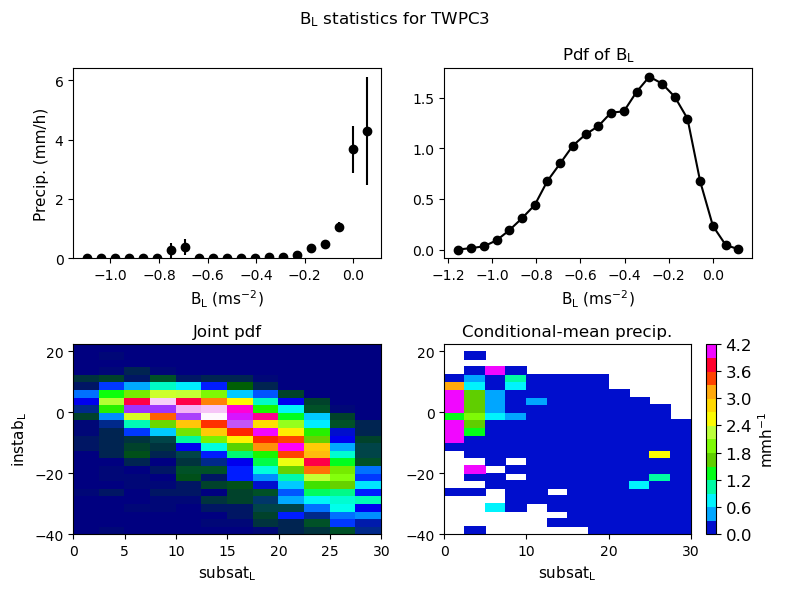

In [164]:
region = 'TWPC3'  # select region from 'TWPC1', 'TWPC2', 'TWPC3', 'CACTI'
ds = pb_dict[region]  # 
plt_dir = './'  # select plot directory 

plot_params = dict(color = 'black', xlabel = "$\mathrm{B_L}$ ($\mathrm{ms^{-2}}$)", 
                   ylabel = "Precip. (mm/h)", plt_title = region, plt_dir = './')

with warnings.catch_warnings():  # context manager to supress warnings
    warnings.simplefilter("ignore")
    plot_bl_stats(ds, plot_params, SAVE_PLOT = False)

In [145]:
# process pooled data
new_ds = pb_dict['TWPC1'] + pb_dict['TWPC2'] + pb_dict['TWPC3']
new_ds.bin_precip_1D()
new_ds.bin_precip_2D()

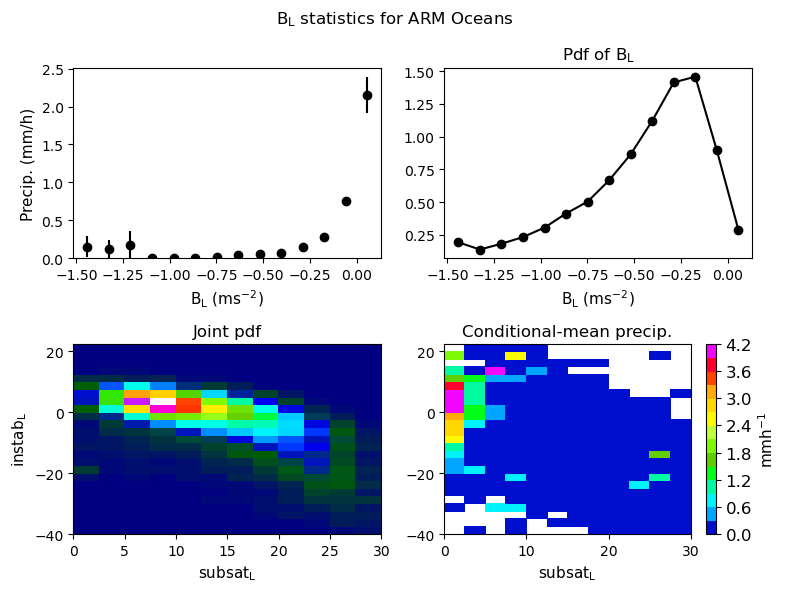

In [146]:
ds = new_ds
plot_params.update(plt_title = 'ARM Oceans')
plot_params.update(color = 'black', xlabel = "$\mathrm{B_L}$ ($\mathrm{ms^{-2}}$)", 
                   ylabel = "Precip. (mm/h)",plt_dir = './')
with warnings.catch_warnings():  # context manager to supress warnings
    warnings.simplefilter("ignore")
    plot_bl_stats(ds, plot_params, SAVE_PLOT = False)